## Data Extraction

###### Python Initialization

In [70]:
import matplotlib.pyplot as plt

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

###### Load Study Dataset

In [71]:
studyDf = spark.read.parquet(".data/studyDf.parquet")

###### Summary Statistics for Duration Variables

In [72]:
durationVars = [
    'item_attempt_duration_mins',
    'student_duration_mins',
    'timeliness_duration_mins',
]
studyDf.select(*durationVars).summary().show()

+-------+--------------------------+---------------------+------------------------+
|summary|item_attempt_duration_mins|student_duration_mins|timeliness_duration_mins|
+-------+--------------------------+---------------------+------------------------+
|  count|                     64838|                64401|                   62835|
|   mean|         529.4551965411233|    1339.521363539959|      19557.169457838827|
| stddev|        3472.1872742858272|    6329.121880145659|         25314.287749887|
|    min|        -54766.01666666667|                  0.0|                 -2751.2|
|    25%|       0.43333333333333335|                11.35|                  2230.9|
|    50%|                      1.85|                 27.9|       7781.166666666667|
|    75%|                       9.7|   271.56666666666666|      27825.066666666666|
|    max|                  109353.1|   261008.16666666666|               144985.15|
+-------+--------------------------+---------------------+------------------

The timeliness_duration_mins has negative values.  This could be due to end dates before
start dates or null dates.

All variables have values 100,000 or more above the fourth quartile.

###### Histogram of duration variables

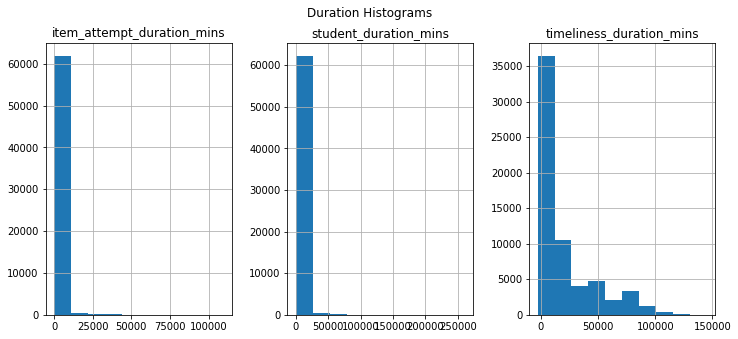

In [102]:
fig, ax = plt.subplots(ncols=3 ,figsize=(12,5))

studyDf.select('item_attempt_duration_mins').toPandas().hist(ax=ax[0])
studyDf.select('student_duration_mins').toPandas().hist(ax=ax[1])
studyDf.select('timeliness_duration_mins').toPandas().hist(ax=ax[2])
plt.suptitle("Duration Histograms")
plt.show()

All plots right skewed with a long tail

###### Plot the date time variables against duration

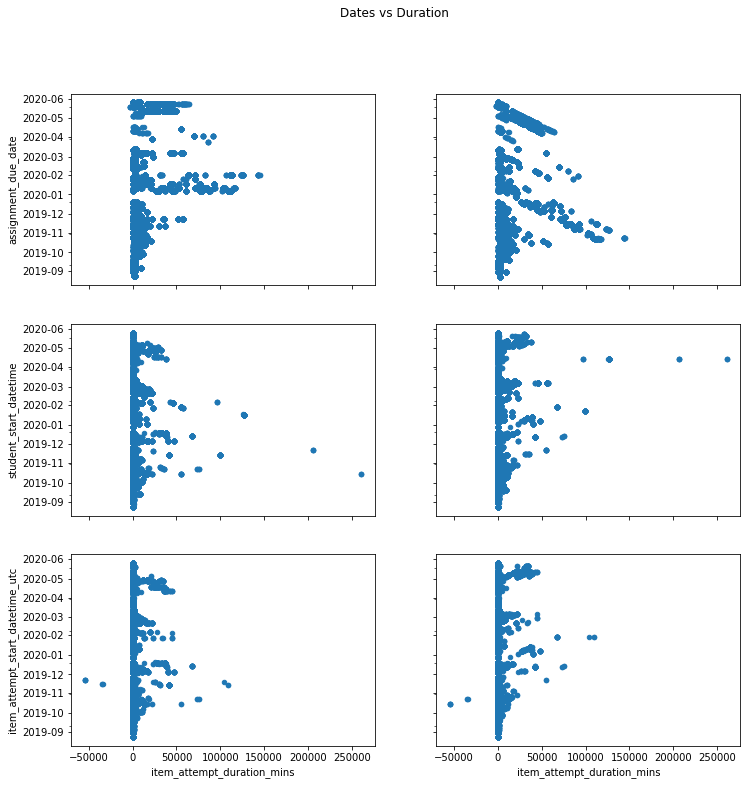

In [73]:
pdDf = studyDf.toPandas()
fig, ax = plt.subplots(ncols=2, nrows=3, sharey=True, sharex=True ,figsize=(12,12))

pdDf.plot('timeliness_duration_mins', 'assignment_due_date',    kind='scatter', ax=ax[0,0])
pdDf.plot('timeliness_duration_mins', 'student_start_datetime', kind='scatter', ax=ax[0,1])

pdDf.plot('student_duration_mins', 'student_start_datetime', kind='scatter', ax=ax[1,0])
pdDf.plot('student_duration_mins', 'student_stop_datetime',  kind='scatter', ax=ax[1,1])

pdDf.plot('item_attempt_duration_mins', 'item_attempt_start_datetime_utc', kind='scatter', ax=ax[2,0])
pdDf.plot('item_attempt_duration_mins', 'item_attempt_end_datetime_utc',   kind='scatter', ax=ax[2,1])

plt.suptitle("Dates vs Duration")
plt.show()

Outliers appear random and low percentage of observations.

In [74]:
studyDf.printSchema()

root
 |-- item_attempt_duration_mins: double (nullable = true)
 |-- student_duration_mins: double (nullable = true)
 |-- timeliness_duration_mins: double (nullable = true)
 |-- item_type_code_name: string (nullable = true)
 |-- number_of_distinct_instance_items: integer (nullable = true)
 |-- raw_score: integer (nullable = true)
 |-- assignment_due_date: timestamp (nullable = true)
 |-- student_start_datetime: timestamp (nullable = true)
 |-- student_stop_datetime: timestamp (nullable = true)
 |-- item_attempt_start_datetime_utc: timestamp (nullable = true)
 |-- item_attempt_end_datetime_utc: timestamp (nullable = true)



###### Display percentage of outliers

In [75]:
def get_iqr_filter(df, col):
  # Only positive (negative are a different problem)
  pdDf = df.filter(F.col(col) >= 0).select(col).toPandas()
  Q1 = pdDf[col].quantile(0.25)
  Q3 = pdDf[col].quantile(0.75)
  median = pdDf[col].quantile(0.50)

  IQR = Q3 - Q1

  outlier = (Q3 + 1.5 * IQR)

  return median, outlier

# Get outlier values
(median, timeOutlier) = get_iqr_filter(studyDf, 'timeliness_duration_mins')
(median, stuOutlier)  = get_iqr_filter(studyDf, 'student_duration_mins')
(median, itemOutlier) = get_iqr_filter(studyDf, 'item_attempt_duration_mins')
# Get all counts
allCnt = studyDf.filter(
       ( F.col('timeliness_duration_mins')   > timeOutlier )
     | ( F.col('student_duration_mins')      > stuOutlier  )
     | ( F.col('item_attempt_duration_mins') > itemOutlier )
).count()
# Get counts by variable
timeCnt = studyDf.filter( F.col('timeliness_duration_mins')   > timeOutlier ).count()
stuCnt  = studyDf.filter( F.col('student_duration_mins')      > stuOutlier ).count()
itemCnt = studyDf.filter( F.col('item_attempt_duration_mins') > itemOutlier ).count()
fullCnt = studyDf.count()

print('All observations with Outliers:    ', allCnt, round(allCnt / fullCnt * 100), '%')
print('Time observations with Outliers:   ', timeCnt, round(timeCnt / fullCnt * 100), '%')
print('Student observations with Outliers:', stuCnt, round(stuCnt / fullCnt * 100), '%')
print('Item observations with Outliers:   ', itemCnt, round(itemCnt / fullCnt * 100), '%')

All observations with Outliers:     21578 33 %
Time observations with Outliers:    5125 8 %
Student observations with Outliers: 13915 21 %
Item observations with Outliers:    9324 14 %


Note: include quote on IQR
Over 33% of the observations have outliers, with a majority (21%) from student_duration_mins and 14% from
item_attempt_duration_mins.  Since this is a large portion of observations, it could impact the outcome.
Since logistic regression is sensitive to outliers, leaving them may impact the outcome more. As a result,
the outliers wil be imputed with the median after the data is split

###### Count null dates

In [76]:
intervalVars = [
    'assignment_due_date',
    'student_start_datetime',
    'student_stop_datetime',
    'item_attempt_start_datetime_utc',
    'item_attempt_end_datetime_utc'
]

studyDf.agg(
        *(F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in intervalVars)
).show()

+-------------------+----------------------+---------------------+-------------------------------+-----------------------------+
|assignment_due_date|student_start_datetime|student_stop_datetime|item_attempt_start_datetime_utc|item_attempt_end_datetime_utc|
+-------------------+----------------------+---------------------+-------------------------------+-----------------------------+
|               1566|                   437|                  437|                              0|                            0|
+-------------------+----------------------+---------------------+-------------------------------+-----------------------------+



1,566 observations have null assignment_due_dates.  437 have null student_start_datetime and student_stop_datetime.
Since this is a low percentage of all observations, they will be deleted.

###### Delete Null Dates

In [77]:
studyDf = studyDf.filter(
    F.col('assignment_due_date').isNotNull()
    & F.col('student_start_datetime').isNotNull()
    & F.col('student_stop_datetime').isNotNull()
)

###### Display any remaining null dates

In [78]:
studyDf.agg(
        *(F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in intervalVars)
).show()


+-------------------+----------------------+---------------------+-------------------------------+-----------------------------+
|assignment_due_date|student_start_datetime|student_stop_datetime|item_attempt_start_datetime_utc|item_attempt_end_datetime_utc|
+-------------------+----------------------+---------------------+-------------------------------+-----------------------------+
|                  0|                     0|                    0|                              0|                            0|
+-------------------+----------------------+---------------------+-------------------------------+-----------------------------+



All null dates remove

###### Remove Stop Dates Before Start Dates

In [79]:
beforeCnt = studyDf.count()
# Keep dates where start is less than or the same as the end date
studyDf = studyDf.filter( F.col('item_attempt_start_datetime_utc') <= F.col('item_attempt_end_datetime_utc') )

print ("Removed:", beforeCnt - studyDf.count())

Removed: 8


In [80]:
beforeCnt = studyDf.count()
# Keep dates where start is less than or the same as the end date
study2Df = studyDf.filter( F.col('item_attempt_start_datetime_utc') <= F.col('item_attempt_end_datetime_utc') )

print ("Removed:", beforeCnt - study2Df.count())


Removed: 0


##### Categorical Nominal item_type_code_name Variable Levels

In [81]:
studyDf.groupBy('item_type_code_name').count().orderBy('count', ascending=False).show()

+-------------------+-----+
|item_type_code_name|count|
+-------------------+-----+
|     multipleChoice|26492|
|     fillInTheBlank|10494|
|      equationEntry| 7841|
|          trueFalse| 4420|
|              cloze| 3021|
|     multipleSelect| 2288|
|           graphing| 2076|
|       choiceMatrix| 1202|
|           matching|  911|
|         selectText|  810|
|        shortAnswer|  803|
|          bucketing|  799|
|           sortable|  547|
|              essay|  521|
|         numberLine|  302|
|            aheAlgo|  219|
|         imageLabel|   80|
|         fileUpload|    1|
+-------------------+-----+



The variable has 18 levels. Categorical variables with a high number of levels can cause high dimensionality
and cause the model to generalize poorly.  These will be converted to continuous variables using smoothed
weight of evidence.


###### number_of_distinct_instance_items and raw_score statistics

In [82]:
studyDf.describe(['number_of_distinct_instance_items', 'raw_score']).show()
print("Total Count:", studyDf.count())

+-------+---------------------------------+------------------+
|summary|number_of_distinct_instance_items|         raw_score|
+-------+---------------------------------+------------------+
|  count|                            62827|             62803|
|   mean|               18.800658952361246|1.0620989443179465|
| stddev|                14.75115991230749| 1.863515224692837|
|    min|                                1|                 0|
|    max|                               60|                46|
+-------+---------------------------------+------------------+

Total Count: 62827


raw_score has a count of 62803.  With a total count of 62827, that means it has 24 null values.  Since this study
is is for completed and fully scored questions, these will be deleted

###### Delete null raw_score observations

In [83]:
beforeCnt = studyDf.count()
studyDf = studyDf.filter( F.col('raw_score').isNotNull() )
afterCnt = studyDf.count()
print('Removed:', beforeCnt - afterCnt)

Removed: 24


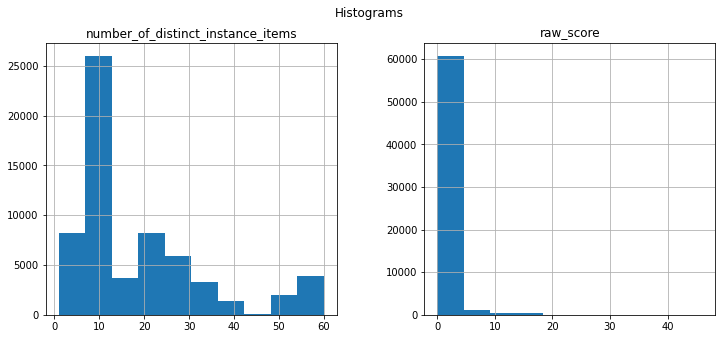

In [84]:
fig, ax = plt.subplots(ncols=2 ,figsize=(12,5))

studyDf.select('number_of_distinct_instance_items').toPandas().hist(ax=ax[0])
studyDf.select('raw_score').toPandas().hist(ax=ax[1])
plt.suptitle("Histograms")
plt.show()

Values are right skewed in both.

###### Convert target variable raw_score to either 0 or 1


In [85]:
studyDf =  studyDf.withColumn(
            'target',
            F.when(F.col('raw_score') > 0, 1).otherwise(0)
          )

###### Split Into Training and Validation sets
- To perform an honest assessment, .....

In [86]:
studyVars = [
    'item_attempt_duration_mins',
    'student_duration_mins',
    'timeliness_duration_mins',
    'item_type_code_name',
    'number_of_distinct_instance_items',
    'target'
]
trainDf, validDf = studyDf.select(*studyVars).randomSplit([0.75, 0.25], 11112020)

print ("Training:  ", trainDf.count())
print ("Validation:", validDf.count())

Training:   47201
Validation: 15602


To prevent leakage (insert ref) between training and validation datasets, the imputation will be
preformed on each dataset individually.

In [87]:
def add_swoe(df, c):
  # Proportion of events in sample
  p1 = df.agg(F.avg(F.col('target')).alias('mean')).collect()[0]['mean']

  # Get event and non event counts
  cntDf = df.groupBy('item_type_code_name').agg(
    F.sum(F.when(F.col('target') == 1, 1).otherwise(0)).alias('1'),
    F.sum(F.when(F.col('target') == 0, 1).otherwise(0)).alias('0')
  )
  swoeVar = 'item_type_code_name' + '_swoe'

  # Add variable with smo
  cntDf = cntDf.withColumn(
    'item_type_code_name_swoe',
    F.log(
      (F.col('1') + c * p1)
      /
      (F.col('0') + c * (1 - p1))
    )
  )
  # Append column to original table name
  return df.join(cntDf.select('item_type_code_name', 'item_type_code_name_swoe'), 'item_type_code_name')

In [88]:
def impute_steps(df):
    # Convert item_type_code_name to SWOE
    df = add_swoe(df, 24)

    # Impute duration outliers
    (timeMedian, timeOutlier) = get_iqr_filter(df, 'timeliness_duration_mins')
    (stuMedian,  stuOutlier)  = get_iqr_filter(df, 'student_duration_mins')
    (itemMedian, itemOutlier) = get_iqr_filter(df, 'item_attempt_duration_mins')
    df = df.withColumn(
      'timeliness_duration_mins',
      F.when( F.col('timeliness_duration_mins') > timeOutlier, timeMedian ).otherwise(F.col('timeliness_duration_mins'))
    ).withColumn(
      'student_duration_mins',
      F.when( F.col('student_duration_mins') > stuOutlier, stuMedian ).otherwise(F.col('student_duration_mins'))
    ).withColumn(
      'item_attempt_duration_mins',
      F.when( F.col('item_attempt_duration_mins') > itemOutlier, itemMedian ).otherwise(F.col('item_attempt_duration_mins'))
    )
    return df

###### Impute Training and Validation Datasets

In [89]:
trainDf = impute_steps(trainDf)
validDf = impute_steps(validDf)

###### Duration Outliers after imputation

In [90]:
trainDf.select(*durationVars).summary().show()

+-------+--------------------------+---------------------+------------------------+
|summary|item_attempt_duration_mins|student_duration_mins|timeliness_duration_mins|
+-------+--------------------------+---------------------+------------------------+
|  count|                     47201|                47201|                   47201|
|   mean|        3.5197114467924813|   46.959548526520344|      13201.205804609328|
| stddev|         4.981094631640023|   102.90865339858942|      15632.387010437034|
|    min|                       0.0|                  0.0|                 -2751.2|
|    25%|       0.48333333333333334|   12.266666666666667|       2230.616666666667|
|    50%|        1.9666666666666666|   28.916666666666668|       7780.216666666666|
|    75%|         3.716666666666667|    32.11666666666667|                16442.05|
|    max|                      24.6|    768.5333333333333|       64108.88333333333|
+-------+--------------------------+---------------------+------------------

No more outliers in duration variables.  Max values

###### Histogram of duration variables

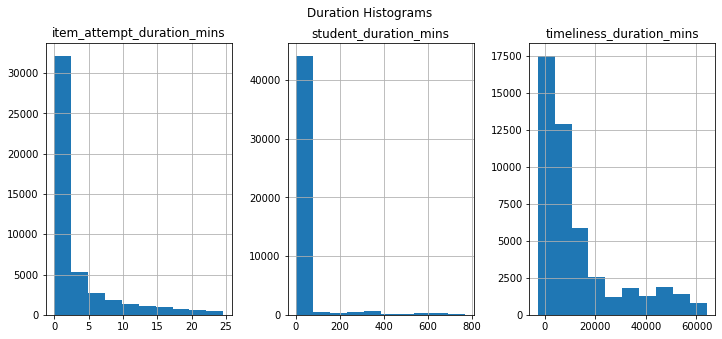

In [103]:
fig, ax = plt.subplots(ncols=3 ,figsize=(12,5))

trainDf.select('item_attempt_duration_mins').toPandas().hist(ax=ax[0])
trainDf.select('student_duration_mins').toPandas().hist(ax=ax[1])
trainDf.select('timeliness_duration_mins').toPandas().hist(ax=ax[2])
plt.suptitle("Duration Histograms")
plt.show()

Tail is much shorter on all plots

###### Results of SWOE Converstion

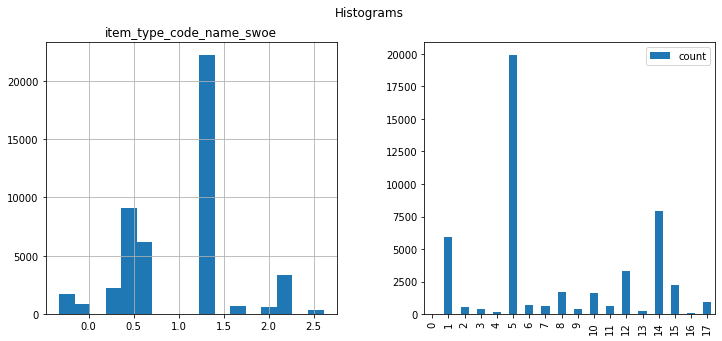

In [100]:
fig, ax = plt.subplots(ncols=2 ,figsize=(12,5))

trainDf.select('item_type_code_name_swoe').toPandas().hist(bins=17, ax=ax[0])
trainDf.groupBy('item_type_code_name').count().toPandas().plot.bar(ax=ax[1])
plt.suptitle("Categorical vs SWOE Values")
plt.show()

The values correctly converted to smoothed weight of evidence.  Though the order is different,
there are the same number of each bar length.

In [91]:
trainDf.repartition(1).write.mode('overwrite').parquet(".data/trainDf.parquet")
validDf.repartition(1).write.mode('overwrite').parquet(".data/validDf.parquet")

